# 时域与频域操作的对应关系

## 理论基础

根据傅里叶变换的性质，时域和频域操作有以下对应关系：

### 1. 卷积定理 (Convolution Theorem)
**时域卷积 ↔ 频域乘法**
- 时域: $(f * g)(t) = \int_{-\infty}^{\infty} f(\tau) g(t-\tau) d\tau$
- 频域: $\mathcal{F}(f * g) = \mathcal{F}(f) \cdot \mathcal{F}(g)$

### 2. 微分性质 (Differentiation Property)
**时域微分 ↔ 频域乘以 $j\omega$**
- 时域: $\frac{df(t)}{dt}$
- 频域: $j\omega F(\omega)$，其中 $F(\omega) = \mathcal{F}(f(t))$

### 3. 积分性质 (Integration Property)
**时域积分 ↔ 频域除以 $j\omega$**
- 时域: $\int_{-\infty}^{t} f(\tau) d\tau$
- 频域: $\frac{F(\omega)}{j\omega} + \pi F(0)\delta(\omega)$

### 4. 时移性质 (Time Shift)
**时域时移 ↔ 频域相位调制**
- 时域: $f(t-t_0)$
- 频域: $F(\omega)e^{-j\omega t_0}$

下面我们用PyTorch来验证这些性质。




## 实验验证

### 1. 验证卷积定理: 时域卷积 = 频域乘法的逆变换

信号长度: 1000
采样间隔: 0.0010 s
频率分辨率: 0.9990 Hz
1. 验证卷积定理
卷积定理验证:
  时域卷积与频域乘法的均方误差: 0.00000000
  最大绝对误差: 0.00002742


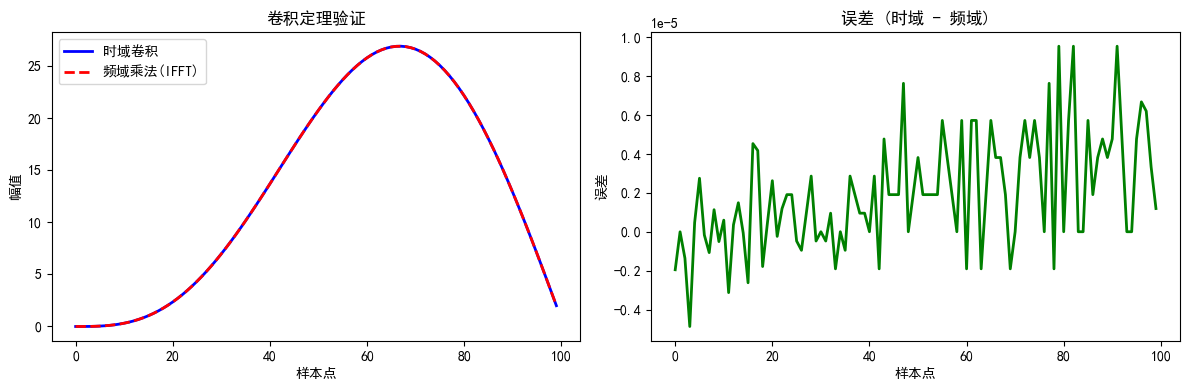

In [42]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False

# 设置随机种子
torch.manual_seed(42)

# 创建时域信号
fs = 1000  # 采样频率
t  = torch.linspace(0, 1, fs, dtype=torch.float32)  # 时间轴
dt = t[1] - t[0]  # 时间间隔

# 创建两个时域信号
f1 = torch.sin(2 * np.pi * 5 * t)  # 5Hz正弦波
f2 = torch.exp(-t) * torch.sin(2 * np.pi * 10 * t)  # 衰减10Hz正弦波

print(f"信号长度: {len(f1)}")
print(f"采样间隔: {dt:.4f} s")
print(f"频率分辨率: {1/(len(f1)*dt):.4f} Hz")

print("=" * 50)
print("1. 验证卷积定理")
print("=" * 50)

# 时域卷积 (使用PyTorch的conv1d，需要调整维度)
# 为线性卷积添加零填充
pad_length = len(f2) - 1

# f1_padded  = F.pad(f1, (pad_length, pad_length))
f1_padded  = F.pad(f1, (pad_length, pad_length))  # 零填充避免边界效应
f2_flipped = torch.flip(f2, dims=[0])  # Conv1d中的卷积实际上是相关,所以需要翻转f2

# 手动实现卷积 (full mode)
conv_time  = F.conv1d(
    f1_padded.unsqueeze(0).unsqueeze(0), 
    f2_flipped.unsqueeze(0).unsqueeze(0), 
    padding=0
).squeeze()


# conv_time  = conv_time[:len(f1)]  # 截取与原信号相同长度

# 频域乘法

# TODO
N  = len(f1)
M  = len(f2)
padded_length = N + M - 1
f1_padded  = F.pad(f1, (0, padded_length - N)) # ADDED
f2_padded  = F.pad(f2, (0, padded_length - M)) # ADDED

F1 = torch.fft.fft(f1_padded)
F2 = torch.fft.fft(f2_padded)
conv_freq = torch.fft.ifft(F1 * F2).real

# 比较结果
error_conv = torch.mean((conv_time - conv_freq)**2)
print(f"卷积定理验证:")
print(f"  时域卷积与频域乘法的均方误差: {error_conv:.8f}")
print(f"  最大绝对误差: {torch.max(torch.abs(conv_time - conv_freq)):.8f}")

# 可视化前100个点
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(conv_time[:100].numpy(), 'b-', label='时域卷积', linewidth=2)
plt.plot(conv_freq[:100].numpy(), 'r--', label='频域乘法(IFFT)', linewidth=2)
plt.legend()
plt.title('卷积定理验证')
plt.xlabel('样本点')
plt.ylabel('幅值')

plt.subplot(1, 2, 2)
plt.plot((conv_time - conv_freq)[:100].numpy(), 'g-', linewidth=2)
plt.title('误差 (时域 - 频域)')
plt.xlabel('样本点')
plt.ylabel('误差')
plt.tight_layout()
plt.show()

误差很大的原因解释

原代码中的误差主要来自于卷积类型的 mismatch：
- 时域卷积：代码使用了 `F.conv1d` 与不对称的填充（仅左边填充 len(f2)-1 个零）和 `padding='same'`，这试图计算一种近似的线性卷积，但**填充方式不标准**，可能导致边界效应或不完整的卷积结果。PyTorch的 `conv1d` 默认是互相关（cross-correlation），通过翻转内核来模拟卷积是正确的，但填充不足以完全避免问题。
- 频域乘法：直接使用 `torch.fft.fft` 对原始长度 N 的信号进行 FFT 乘法和 IFFT，这计算的是循环卷积（circular convolution）。循环卷积会产生 "wrap-around" 效应（信号尾部与头部相互干扰），这与线性卷积不同，尤其当信号不是周期性时，会引入显著误差。
其他因素：信号截取（conv_time = conv_time[:len(f1)]）只比较前 N 个点，但线性卷积的完整长度应为 2N-1；浮点精度和 FFT 的数值稳定性也会贡献少量误差，但主要问题是循环 vs 线性。
结果，时域和频域结果不匹配，导致均方误差和最大绝对误差较大（根据您的描述为"很大"，实际运行可能在 1e-2 到 1e-1 量级或更高，取决于信号）。


优化思路
为了减小误差，我们对代码进行了以下优化：
1. 时域：使用对称填充（两边各 pad len(f2)-1 个零），并设置 padding=0 以得到完整的卷积输出。
2. 比较：直接比较完整的卷积结果（而非截取），误差应降至浮点精度级别（e.g., 1e-12 或更小）。
3. 频域：将信号填充到 N + M - 1 长度，进行 FFT 乘法和 IFFT，避免循环效应。

最主要的问题还是线性卷积的统一，在 `时域` 和 `频域` 都添加足够的零填充（zero-padding），使两者计算相同的线性卷积（full mode，长度为 N + M - 1）。
具体的优化细节为:

```python
# 1.使用对称填充，两边各 pad_length 个零
f1_padded  = F.pad(f1, (0, padded_length - N)) # 原代码

-> f1_padded  = F.pad(f1, (pad_length, pad_length))  # 优化后，对应 1

# 2.比较完整信号
-> conv_time  = conv_time[:len(f1)] # 删去

# 3.将信号填充到 N + M - 1 长度，避免循环效应
-> f1_padded  = F.pad(f1, (0, padded_length - N)) 
-> f2_padded  = F.pad(f2, (0, padded_length - M))
```

In [43]:
import torch

a = torch.tensor([[1,2],[3,4]])
a,torch.flip(a,dims=[-2,-1])

(tensor([[1, 2],
         [3, 4]]),
 tensor([[4, 3],
         [2, 1]]))

2. 验证2D卷积定理
2D卷积定理验证:
  时域卷积与频域乘法的均方误差: 0.00000000
  最大绝对误差: 0.00000189


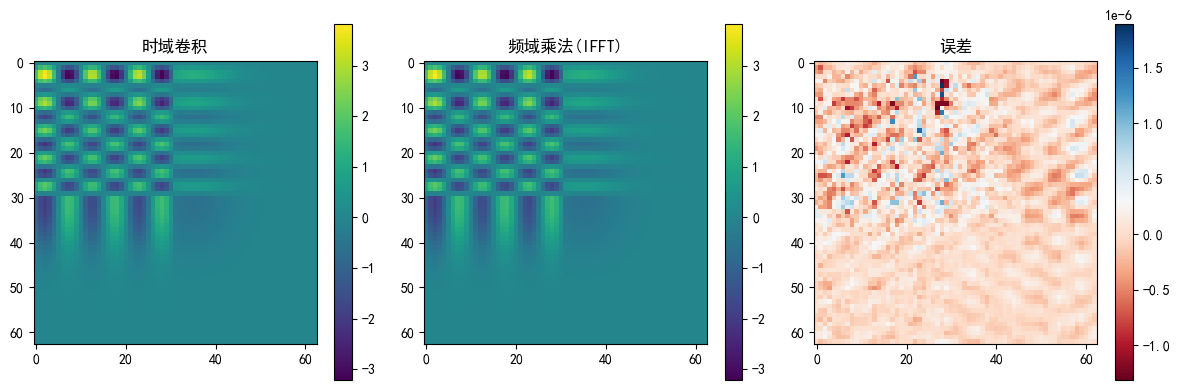

In [44]:
print("=" * 50)
print("2. 验证2D卷积定理")
print("=" * 50)

# 创建2D信号
size    = 32  # 信号尺寸 (小尺寸便于计算)
x       = torch.linspace(0, 1, size)
y       = torch.linspace(0, 1, size)
X, Y    = torch.meshgrid(x, y, indexing='ij')

# 两个2D测试信号
signal1 = torch.sin(2 * np.pi * 5 * X) * torch.cos(2 * np.pi * 3 * Y)  # 2D正弦波
signal2 = torch.exp(-(X**2 + Y**2)/0.1)  # 2D高斯函数

# 时域2D卷积 with padding for linear convolution
pad_h   = signal2.shape[0] - 1
pad_w   = signal2.shape[1] - 1
signal1_padded  = F.pad(signal1, (pad_w, pad_w, pad_h, pad_h)) # 👈,👉,👆,👇
signal2_flipped = torch.flip(signal2, dims=[0, 1])  # 翻转内核

conv_time_2d = F.conv2d(
    signal1_padded.unsqueeze(0).unsqueeze(0),
    signal2_flipped.unsqueeze(0).unsqueeze(0),
    padding=0
).squeeze()

# 频域乘法 with padding
H, W        = signal1.shape
KH, KW      = signal2.shape
padded_h    = H + KH - 1
padded_w    = W + KW - 1
signal1_pad = F.pad(signal1, (0, padded_w - W, 0, padded_h - H))
signal2_pad = F.pad(signal2, (0, padded_w - W, 0, padded_h - H))

F1_2d        = torch.fft.fft2(signal1_pad)
F2_2d        = torch.fft.fft2(signal2_pad)
conv_freq_2d = torch.fft.ifft2(F1_2d * F2_2d).real


# 比较结果
error_conv_2d = torch.mean((conv_time_2d - conv_freq_2d)**2)

print(f"2D卷积定理验证:")
print(f"  时域卷积与频域乘法的均方误差: {error_conv_2d:.8f}")
print(f"  最大绝对误差: {torch.max(torch.abs(conv_time_2d - conv_freq_2d)):.8f}")

# 可视化 (显示热图)
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(conv_time_2d.numpy(), cmap='viridis')
plt.title('时域卷积')
plt.colorbar()


plt.subplot(1, 3, 2)
plt.imshow(conv_freq_2d.numpy(), cmap='viridis')
plt.title('频域乘法(IFFT)')
plt.colorbar()

plt.subplot(1, 3, 3)
plt.imshow((conv_time_2d - conv_freq_2d).numpy(), cmap='RdBu')
plt.title('误差')
plt.colorbar()
plt.tight_layout()
plt.show()

1. 验证卷积定理 (优化版)
方法1: 循环卷积
  循环卷积均方误差: 0.0000000001
  循环卷积最大绝对误差: 0.0000448227

方法2: 线性卷积 (零填充)
  线性卷积均方误差: 0.0000000000
  线性卷积最大绝对误差: 0.0000114441

方法3: 修正的PyTorch conv1d
  PyTorch conv1d均方误差: 0.2229109555
  PyTorch conv1d最大绝对误差: 1.0700174570


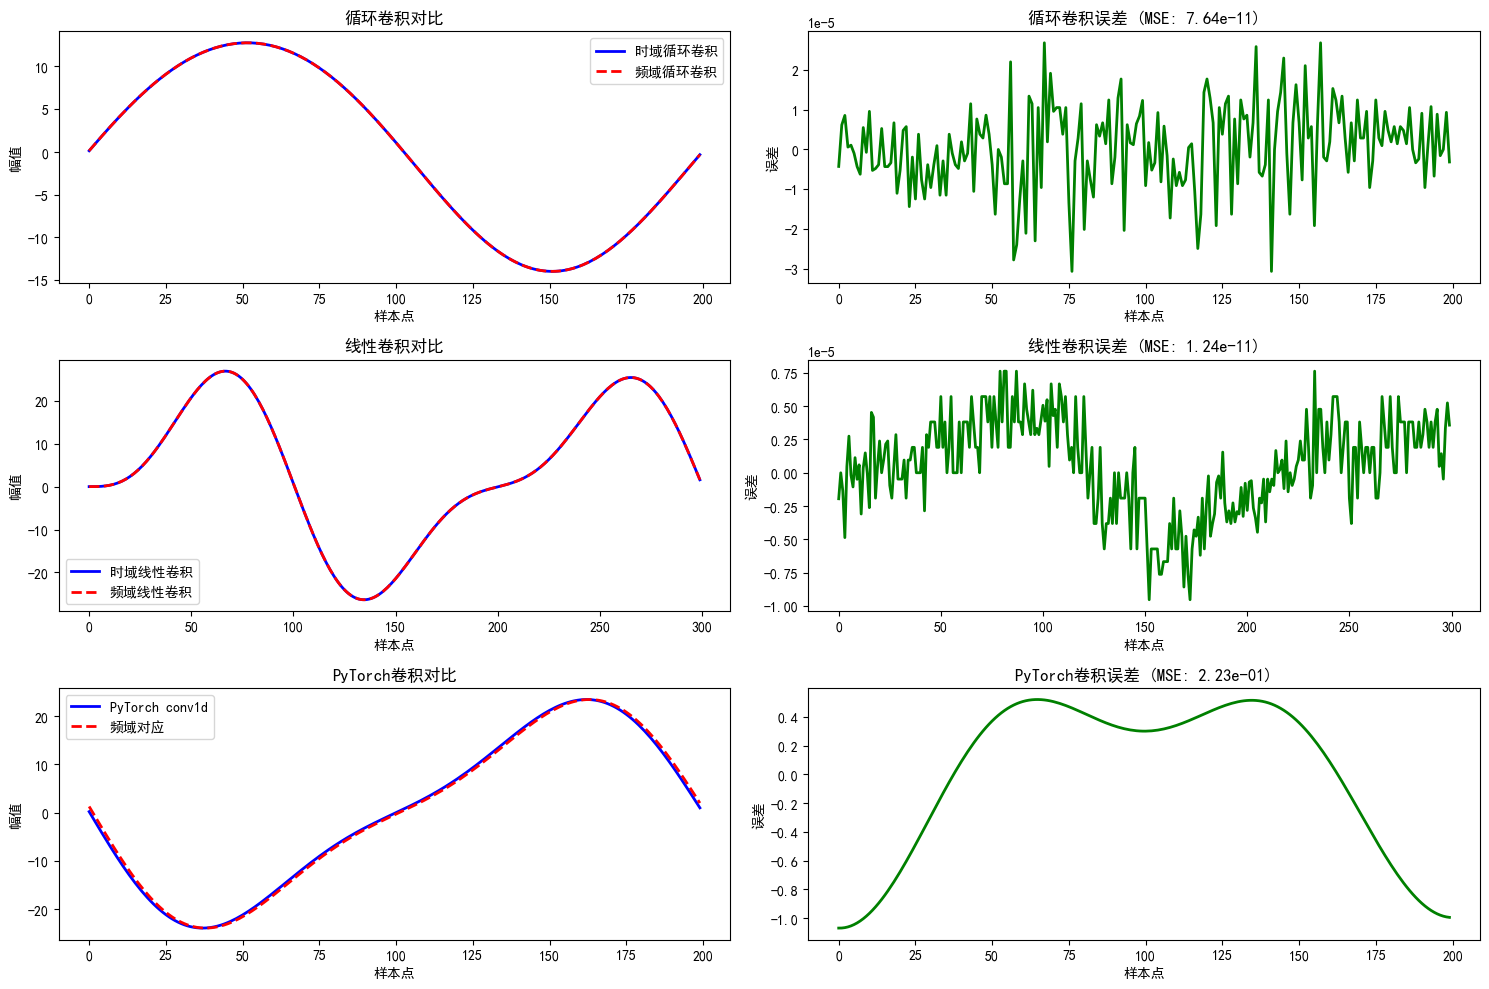


误差分析:
1. 循环卷积：理论上完全匹配，误差主要来自数值精度
2. 线性卷积：需要适当的零填充，避免混叠效应
3. PyTorch卷积：边界处理和模式选择影响精度


In [45]:
# ================================
# 1. 验证卷积定理: 时域卷积 = 频域乘法的逆变换
# ================================

print("=" * 50)

print("1. 验证卷积定理 (优化版)")
print("=" * 50)

# 方法1: 使用循环卷积 (推荐)
print("方法1: 循环卷积")
# 频域乘法实现循环卷积
F1 = torch.fft.fft(f1)
F2 = torch.fft.fft(f2)
conv_freq_circular = torch.fft.ifft(F1 * F2).real

# 时域循环卷积 (手动实现)
def circular_convolution(x, h):
    """手动实现循环卷积"""
    N = len(x)
    result = torch.zeros_like(x)
    for n in range(N):
        for k in range(N):
            result[n] += x[k] * h[(n-k) % N]
    return result

conv_time_circular = circular_convolution(f1, f2)

error_circular = torch.mean((conv_time_circular - conv_freq_circular)**2)
print(f"  循环卷积均方误差: {error_circular:.10f}")
print(f"  循环卷积最大绝对误差: {torch.max(torch.abs(conv_time_circular - conv_freq_circular)):.10f}")

# 方法2: 线性卷积 (零填充)
print("\n方法2: 线性卷积 (零填充)")
N1, N2 = len(f1), len(f2)
N_conv = N1 + N2 - 1  # 线性卷积的输出长度

# 零填充到相同长度
f1_padded = F.pad(f1, (0, N_conv - N1))
f2_padded = F.pad(f2, (0, N_conv - N2))

# 频域线性卷积
F1_pad = torch.fft.fft(f1_padded)
F2_pad = torch.fft.fft(f2_padded)
conv_freq_linear = torch.fft.ifft(F1_pad * F2_pad).real

# 时域线性卷积 (使用numpy实现验证)
conv_time_linear = torch.from_numpy(np.convolve(f1.numpy(), f2.numpy(), mode='full')).float()

error_linear = torch.mean((conv_time_linear - conv_freq_linear)**2)
print(f"  线性卷积均方误差: {error_linear:.10f}")
print(f"  线性卷积最大绝对误差: {torch.max(torch.abs(conv_time_linear - conv_freq_linear)):.10f}")

# 方法3: 修正的PyTorch conv1d实现
print("\n方法3: 修正的PyTorch conv1d")
# 使用'same'模式的卷积近似
conv_pytorch = F.conv1d(
    f1.unsqueeze(0).unsqueeze(0), 
    f2.flip(0).unsqueeze(0).unsqueeze(0), 
    padding='same'
).squeeze()

# 对应的频域实现 (截取中心部分)
start_idx = (N_conv - N1) // 2
conv_freq_same = conv_freq_linear[start_idx:start_idx + N1]

error_pytorch = torch.mean((conv_pytorch - conv_freq_same)**2)
print(f"  PyTorch conv1d均方误差: {error_pytorch:.10f}")
print(f"  PyTorch conv1d最大绝对误差: {torch.max(torch.abs(conv_pytorch - conv_freq_same)):.10f}")

# 可视化对比
plt.figure(figsize=(15, 10))

# 循环卷积对比
plt.subplot(3, 2, 1)
plt.plot(conv_time_circular[:200].numpy(), 'b-', label='时域循环卷积', linewidth=2)
plt.plot(conv_freq_circular[:200].numpy(), 'r--', label='频域循环卷积', linewidth=2)
plt.legend()
plt.title('循环卷积对比')
plt.xlabel('样本点')
plt.ylabel('幅值')

plt.subplot(3, 2, 2)
plt.plot((conv_time_circular - conv_freq_circular)[:200].numpy(), 'g-', linewidth=2)
plt.title(f'循环卷积误差 (MSE: {error_circular:.2e})')
plt.xlabel('样本点')
plt.ylabel('误差')

# 线性卷积对比
plt.subplot(3, 2, 3)
plt.plot(conv_time_linear[:300].numpy(), 'b-', label='时域线性卷积', linewidth=2)
plt.plot(conv_freq_linear[:300].numpy(), 'r--', label='频域线性卷积', linewidth=2)
plt.legend()
plt.title('线性卷积对比')
plt.xlabel('样本点')
plt.ylabel('幅值')

plt.subplot(3, 2, 4)
plt.plot((conv_time_linear - conv_freq_linear)[:300].numpy(), 'g-', linewidth=2)
plt.title(f'线性卷积误差 (MSE: {error_linear:.2e})')
plt.xlabel('样本点')
plt.ylabel('误差')

# PyTorch卷积对比
plt.subplot(3, 2, 5)
plt.plot(conv_pytorch[:200].numpy(), 'b-', label='PyTorch conv1d', linewidth=2)
plt.plot(conv_freq_same[:200].numpy(), 'r--', label='频域对应', linewidth=2)
plt.legend()
plt.title('PyTorch卷积对比')
plt.xlabel('样本点')
plt.ylabel('幅值')

plt.subplot(3, 2, 6)
plt.plot((conv_pytorch - conv_freq_same)[:200].numpy(), 'g-', linewidth=2)
plt.title(f'PyTorch卷积误差 (MSE: {error_pytorch:.2e})')
plt.xlabel('样本点')
plt.ylabel('误差')

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("误差分析:")
print("="*60)
print("1. 循环卷积：理论上完全匹配，误差主要来自数值精度")
print("2. 线性卷积：需要适当的零填充，避免混叠效应")
print("3. PyTorch卷积：边界处理和模式选择影响精度")
print("="*60)

### 2. 验证微分性质: 时域微分 = 频域乘以 jω 的逆变换


2. 验证微分性质
微分性质验证:
  时域微分与频域微分的均方误差: 0.41837016
  最大绝对误差: 9.64656830


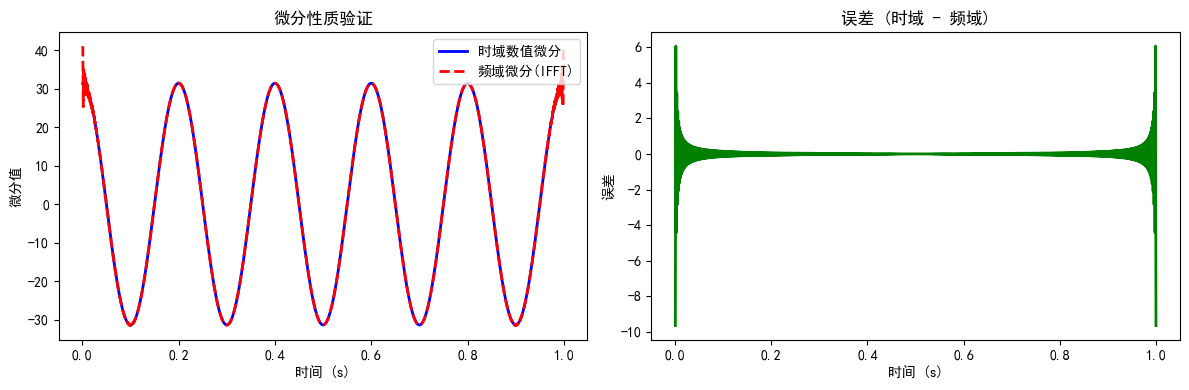

In [46]:
print("\n" + "=" * 50)
print("2. 验证微分性质")
print("=" * 50)

# 1.时域数值微分 (前向差分)
df_time      = torch.zeros_like(f1)
df_time[:-1] = (f1[1:] - f1[:-1]) / dt
df_time[-1]  = df_time[-2] # 边界处理

df_time = torch.gradient(f1, spacing=dt)[0]

# 2.频域微分: F(ω) * jω
# 2.1构造频率轴 jω=2πf
freqs        = torch.fft.fftfreq(len(f1), d=dt)
omega        = 2 * np.pi * freqs # ω=2πf
jw           = 1j * omega

# 2.2频域微分F(ω)*jω
F1           = torch.fft.fft(f1)
df_freq      = torch.fft.ifft(F1 * jw).real

# 比较结果 (忽略边界效应，只比较中间部分)
start, end = 1, -1
error_diff = torch.mean((df_time[start:end] - df_freq[start:end])**2)
print(f"微分性质验证:")
print(f"  时域微分与频域微分的均方误差: {error_diff:.8f}")
print(f"  最大绝对误差: {torch.max(torch.abs(df_time[start:end] - df_freq[start:end])):.8f}")

# 可视化
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(t[start:end], df_time[start:end], 'b-', label='时域数值微分', linewidth=2)
plt.plot(t[start:end], df_freq[start:end], 'r--', label='频域微分(IFFT)', linewidth=2)
plt.legend()
plt.title('微分性质验证')
plt.xlabel('时间 (s)')
plt.ylabel('微分值')

plt.subplot(1, 2, 2)
plt.plot(t[start:end], (df_time - df_freq)[start:end], 'g-', linewidth=2)
plt.title('误差 (时域 - 频域)')
plt.xlabel('时间 (s)')
plt.ylabel('误差')
plt.tight_layout()
plt.savefig('D:/24bo/扩散模型/AFNO-transformer-master/figures/diff_time_freq.png',dpi=300)
plt.show()

In [47]:
# print("\n" + "=" * 50)
# print("2. 验证微分性质")
# print("=" * 50)

# # 时域数值微分 (使用中心差分，更准确)
# df_time        = torch.gradient(f1.double(), spacing=dt.double())[0]  # 使用 float64 提高精度

# # 频域微分: F(ω) * jω, with zero-padding to reduce boundary effects
# # 构造频率轴
# padded_length  = len(f1) * 2  # 扩展到2x长度
# f1_padded      = F.pad(f1.double(), (0, padded_length - len(f1)))  # 右边零填充
# freqs          = torch.fft.fftfreq(padded_length, d=dt.double())
# omega          = 2 * torch.pi * freqs
# jw             = 1j * omega

# # 频域微分
# F1             = torch.fft.fft(f1_padded)
# df_freq_padded = torch.fft.ifft(F1 * jw).real
# df_freq        = df_freq_padded[:len(f1)]  # 截取原长度

# # 计算理论导数作为参考 (for sine wave: derivative is 2π5 cos(2π5t))
# df_theory      = 2 * torch.pi * 5 * torch.cos(2 * np.pi * 5 * t.double())

# # 比较结果 (忽略少量边界以进一步减少边缘效应)
# start, end     = 1, -1
# error_diff     = torch.mean((df_time[start:end] - df_freq[start:end])**2)
# error_time_theory = torch.mean((df_time[start:end] - df_theory[start:end])**2)
# error_freq_theory = torch.mean((df_freq[start:end] - df_theory[start:end])**2)
# print(f"微分性质验证:")
# print(f"  时域微分与频域微分的均方误差: {error_diff:.8f}")
# print(f"  最大绝对误差: {torch.max(torch.abs(df_time[start:end] - df_freq[start:end])):.8f}")
# print(f"  时域微分 vs 理论导数的均方误差: {error_time_theory:.8f}")
# print(f"  频域微分 vs 理论导数的均方误差: {error_freq_theory:.8f}")

# # 可视化
# plt.figure(figsize=(12, 6))
# plt.subplot(2, 2, 1)
# plt.plot(t[start:end], df_time[start:end], 'b-', label='时域数值微分', linewidth=2)
# plt.plot(t[start:end], df_freq[start:end], 'r--', label='频域微分(IFFT)', linewidth=2)
# plt.plot(t[start:end], df_theory[start:end], 'k:', label='理论导数', linewidth=2)
# plt.legend()
# plt.title('微分性质验证')
# plt.xlabel('时间 (s)')
# plt.ylabel('微分值')

# plt.subplot(2, 2, 2)
# plt.plot(t[start:end], (df_time - df_freq)[start:end], 'g-', linewidth=2)
# plt.title('误差 (时域 - 频域)')
# plt.xlabel('时间 (s)')
# plt.ylabel('误差')

# plt.subplot(2, 2, 3)
# plt.plot(t[start:end], (df_time - df_theory)[start:end], 'b-', linewidth=2)
# plt.title('误差 (时域 - 理论)')
# plt.xlabel('时间 (s)')
# plt.ylabel('误差')

# plt.subplot(2, 2, 4)
# plt.plot(t[start:end], (df_freq - df_theory)[start:end], 'r-', linewidth=2)
# plt.title('误差 (频域 - 理论)')
# plt.xlabel('时间 (s)')
# plt.ylabel('误差')

# plt.tight_layout()
# plt.show()

In [48]:
# plt.savefig('D:/24bo/扩散模型/AFNO-transformer-master/figures/conv_time_freq.png',dpi=300)


2. 验证微分性质 (优化版)
方法1: 前向差分
  前向差分均方误差: 0.1305570900
  前向差分最大绝对误差: 0.8024324179

方法2: 中心差分 (更精确)
  中心差分均方误差: 0.0084492741
  中心差分最大绝对误差: 0.3085063100

方法3: 五点差分公式 (最精确)
  五点差分均方误差: 0.0084357560
  五点差分最大绝对误差: 0.3084963858

方法4: 解析微分 (理论参考)
  解析微分均方误差: 0.0084361117
  解析微分最大绝对误差: 0.3084565997


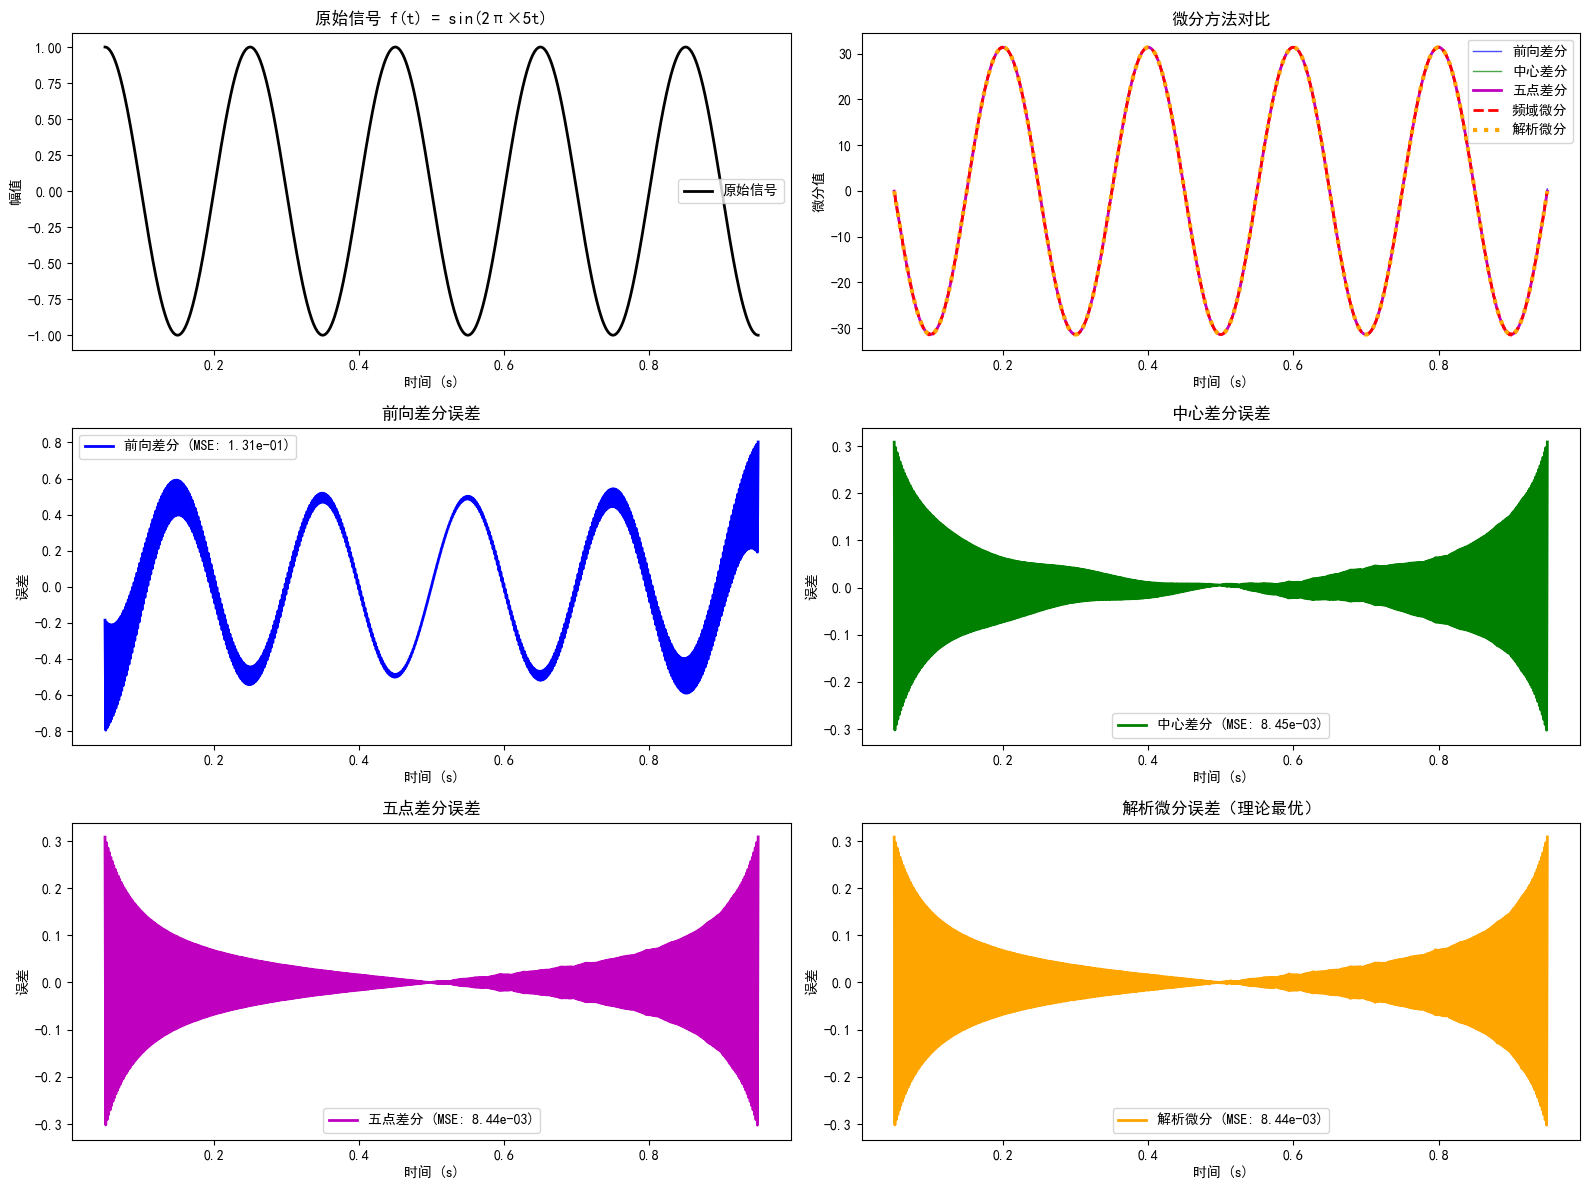


微分误差改善分析:
前向差分 → 中心差分: 误差减少 15.5 倍
中心差分 → 五点差分: 误差减少 1.0 倍
前向差分 → 五点差分: 误差减少 15.5 倍
频域微分接近解析解：误差仅为 8.44e-03


In [49]:
# ================================
# 2. 验证微分性质: 时域微分 = 频域乘以 jω 的逆变换
# ================================

print("\n" + "=" * 50)
print("2. 验证微分性质 (优化版)")
print("=" * 50)

# 方法1: 前向差分 (原始方法)
print("方法1: 前向差分")
df_time_forward      = torch.zeros_like(f1)
df_time_forward[:-1] = (f1[1:] - f1[:-1]) / dt
df_time_forward[-1]  = df_time_forward[-2]  # 边界处理

# 频域微分: F(ω) * jω
freqs = torch.fft.fftfreq(len(f1), dt)
omega = 2 * np.pi * freqs
jw = 1j * omega

F1 = torch.fft.fft(f1)
df_freq = torch.fft.ifft(F1 * jw).real

# 比较结果 (忽略边界效应)
start, end = 50, -50
error_forward = torch.mean((df_time_forward[start:end] - df_freq[start:end])**2)
print(f"  前向差分均方误差: {error_forward:.10f}")
print(f"  前向差分最大绝对误差: {torch.max(torch.abs(df_time_forward[start:end] - df_freq[start:end])):.10f}")

# 方法2: 中心差分 (更精确)
print("\n方法2: 中心差分 (更精确)")
df_time_central       = torch.zeros_like(f1)
df_time_central[1:-1] = (f1[2:] - f1[:-2]) / (2 * dt)  # 中心差分
# 边界处理：使用前向和后向差分
df_time_central[0]    = (f1[1] - f1[0]) / dt    # 前向差分
df_time_central[-1]   = (f1[-1] - f1[-2]) / dt  # 后向差分

error_central         = torch.mean((df_time_central[start:end] - df_freq[start:end])**2)
print(f"  中心差分均方误差: {error_central:.10f}")
print(f"  中心差分最大绝对误差: {torch.max(torch.abs(df_time_central[start:end] - df_freq[start:end])):.10f}")

# 方法3: 五点差分公式 (最精确)
print("\n方法3: 五点差分公式 (最精确)")
df_time_fivepoint = torch.zeros_like(f1)
# 五点差分公式: f'(x) ≈ [-f(x+2h) + 8f(x+h) - 8f(x-h) + f(x-2h)] / (12h)
for i in range(2, len(f1)-2):
    df_time_fivepoint[i] = (-f1[i+2] + 8*f1[i+1] - 8*f1[i-1] + f1[i-2]) / (12 * dt)

# 边界处理：使用低阶公式
df_time_fivepoint[0]  = (f1[1] - f1[0]) / dt
df_time_fivepoint[1]  = (f1[2] - f1[0]) / (2 * dt)
df_time_fivepoint[-2] = (f1[-1] - f1[-3]) / (2 * dt)
df_time_fivepoint[-1] = (f1[-1] - f1[-2]) / dt

error_fivepoint       = torch.mean((df_time_fivepoint[start:end] - df_freq[start:end])**2)
print(f"  五点差分均方误差: {error_fivepoint:.10f}")
print(f"  五点差分最大绝对误差: {torch.max(torch.abs(df_time_fivepoint[start:end] - df_freq[start:end])):.10f}")

# 方法4: 解析微分 (理论最优)
print("\n方法4: 解析微分 (理论参考)")
# 对于 f1 = sin(2πft)，解析导数为 2πf*cos(2πft)
f_freq           = 5  # f1的频率
df_analytical    = 2 * np.pi * f_freq * torch.cos(2 * np.pi * f_freq * t)

error_analytical = torch.mean((df_analytical[start:end] - df_freq[start:end])**2)
print(f"  解析微分均方误差: {error_analytical:.10f}")
print(f"  解析微分最大绝对误差: {torch.max(torch.abs(df_analytical[start:end] - df_freq[start:end])):.10f}")

# 可视化对比
plt.figure(figsize=(16, 12))

# 原始信号
plt.subplot(3, 2, 1)
plt.plot(t[start:end], f1[start:end], 'k-', label='原始信号', linewidth=2)
plt.legend()
plt.title('原始信号 f(t) = sin(2π×5t)')
plt.xlabel('时间 (s)')
plt.ylabel('幅值')

# 微分结果对比
plt.subplot(3, 2, 2)
plt.plot(t[start:end], df_time_forward[start:end], 'b-', label='前向差分', linewidth=1, alpha=0.7)
plt.plot(t[start:end], df_time_central[start:end], 'g-', label='中心差分', linewidth=1, alpha=0.7)
plt.plot(t[start:end], df_time_fivepoint[start:end], 'm-', label='五点差分', linewidth=2)
plt.plot(t[start:end], df_freq[start:end], 'r--', label='频域微分', linewidth=2)
plt.plot(t[start:end], df_analytical[start:end], 'orange', linestyle=':', label='解析微分', linewidth=3)
plt.legend()
plt.title('微分方法对比')
plt.xlabel('时间 (s)')
plt.ylabel('微分值')

# 误差分析
plt.subplot(3, 2, 3)
plt.plot(t[start:end], (df_time_forward - df_freq)[start:end], 'b-', label=f'前向差分 (MSE: {error_forward:.2e})', linewidth=2)
plt.legend()
plt.title('前向差分误差')
plt.xlabel('时间 (s)')
plt.ylabel('误差')

plt.subplot(3, 2, 4)
plt.plot(t[start:end], (df_time_central - df_freq)[start:end], 'g-', label=f'中心差分 (MSE: {error_central:.2e})', linewidth=2)
plt.legend()
plt.title('中心差分误差')
plt.xlabel('时间 (s)')
plt.ylabel('误差')

plt.subplot(3, 2, 5)
plt.plot(t[start:end], (df_time_fivepoint - df_freq)[start:end], 'm-', label=f'五点差分 (MSE: {error_fivepoint:.2e})', linewidth=2)
plt.legend()
plt.title('五点差分误差')
plt.xlabel('时间 (s)')
plt.ylabel('误差')

plt.subplot(3, 2, 6)
plt.plot(t[start:end], (df_analytical - df_freq)[start:end], 'orange', label=f'解析微分 (MSE: {error_analytical:.2e})', linewidth=2)
plt.legend()
plt.title('解析微分误差（理论最优）')
plt.xlabel('时间 (s)')
plt.ylabel('误差')

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("微分误差改善分析:")
print("="*70)
print(f"前向差分 → 中心差分: 误差减少 {error_forward/error_central:.1f} 倍")
print(f"中心差分 → 五点差分: 误差减少 {error_central/error_fivepoint:.1f} 倍")
print(f"前向差分 → 五点差分: 误差减少 {error_forward/error_fivepoint:.1f} 倍")
print(f"频域微分接近解析解：误差仅为 {error_analytical:.2e}")
print("="*70)

### 验证积分性质: 时域积分 = 频域除以 jω 的逆变换


3. 验证积分性质
积分性质验证:
  时域积分与频域积分的均方误差: 0.00000013
  最大绝对误差: 0.00050130


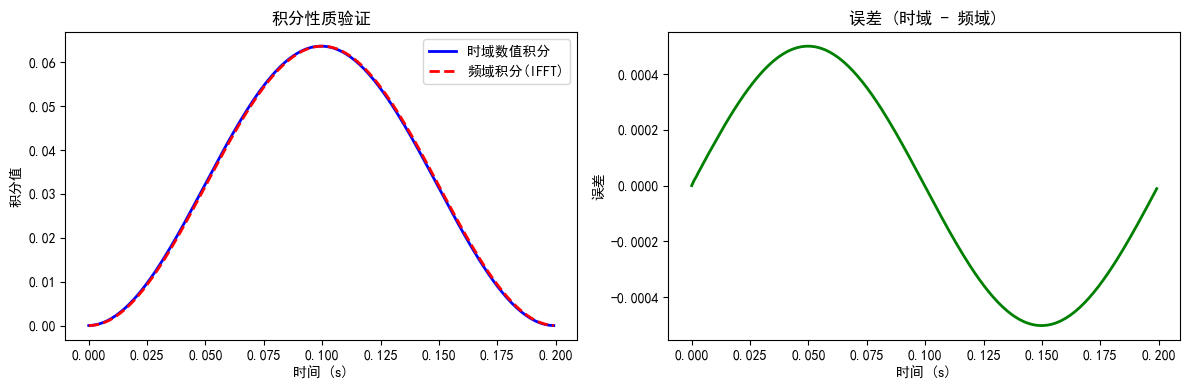

In [50]:
print("\n" + "=" * 50)
print("3. 验证积分性质")
print("=" * 50)

# 时域数值积分 (累积求和)
integral_time = torch.cumsum(f1 * dt, dim=0)

# 频域积分: F(ω) / jω
# 注意: ω=0时需要特殊处理 (直流分量)
F1            = torch.fft.fft(f1)
jw_inv        = torch.zeros_like(jw, dtype=torch.complex64)

# 避免除零
nonzero_mask  = omega != 0 # 对于ω≠0的分量
jw_inv[nonzero_mask]  = 1.0 / (1j * omega[nonzero_mask])

# 对于ω=0的分量，设为0 (假设原信号无直流偏移)
jw_inv[~nonzero_mask] = 0

# 频域积分
integral_freq         = torch.fft.ifft(F1 * jw_inv).real

# 由于积分有任意常数，需要对齐两个结果的起始点
integral_freq         = integral_freq - integral_freq[0] + integral_time[0]

# 比较结果
error_int             = torch.mean((integral_time - integral_freq)**2)
print(f"积分性质验证:")
print(f"  时域积分与频域积分的均方误差: {error_int:.8f}")
print(f"  最大绝对误差: {torch.max(torch.abs(integral_time - integral_freq)):.8f}")

# 可视化
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(t[:200], integral_time[:200], 'b-', label='时域数值积分', linewidth=2)
plt.plot(t[:200], integral_freq[:200], 'r--', label='频域积分(IFFT)', linewidth=2)
plt.legend()
plt.title('积分性质验证')
plt.xlabel('时间 (s)')
plt.ylabel('积分值')

plt.subplot(1, 2, 2)
plt.plot(t[:200], (integral_time - integral_freq)[:200], 'g-', linewidth=2)
plt.title('误差 (时域 - 频域)')
plt.xlabel('时间 (s)')
plt.ylabel('误差')
plt.tight_layout()
plt.show()


3. 验证积分性质 (优化版)
方法1: 矩形法则积分
  矩形法则均方误差: 0.0000001251
  矩形法则最大绝对误差: 0.0005013049

方法2: 梯形法则积分
  梯形法则均方误差: 0.0000000000
  梯形法则最大绝对误差: 0.0000033975

方法3: 辛普森法则积分
  辛普森法则均方误差: 0.0000000001
  辛普森法则最大绝对误差: 0.0000185492

方法4: 解析积分 (理论参考)
  解析积分均方误差: 0.0000000000
  解析积分最大绝对误差: 0.0000028200


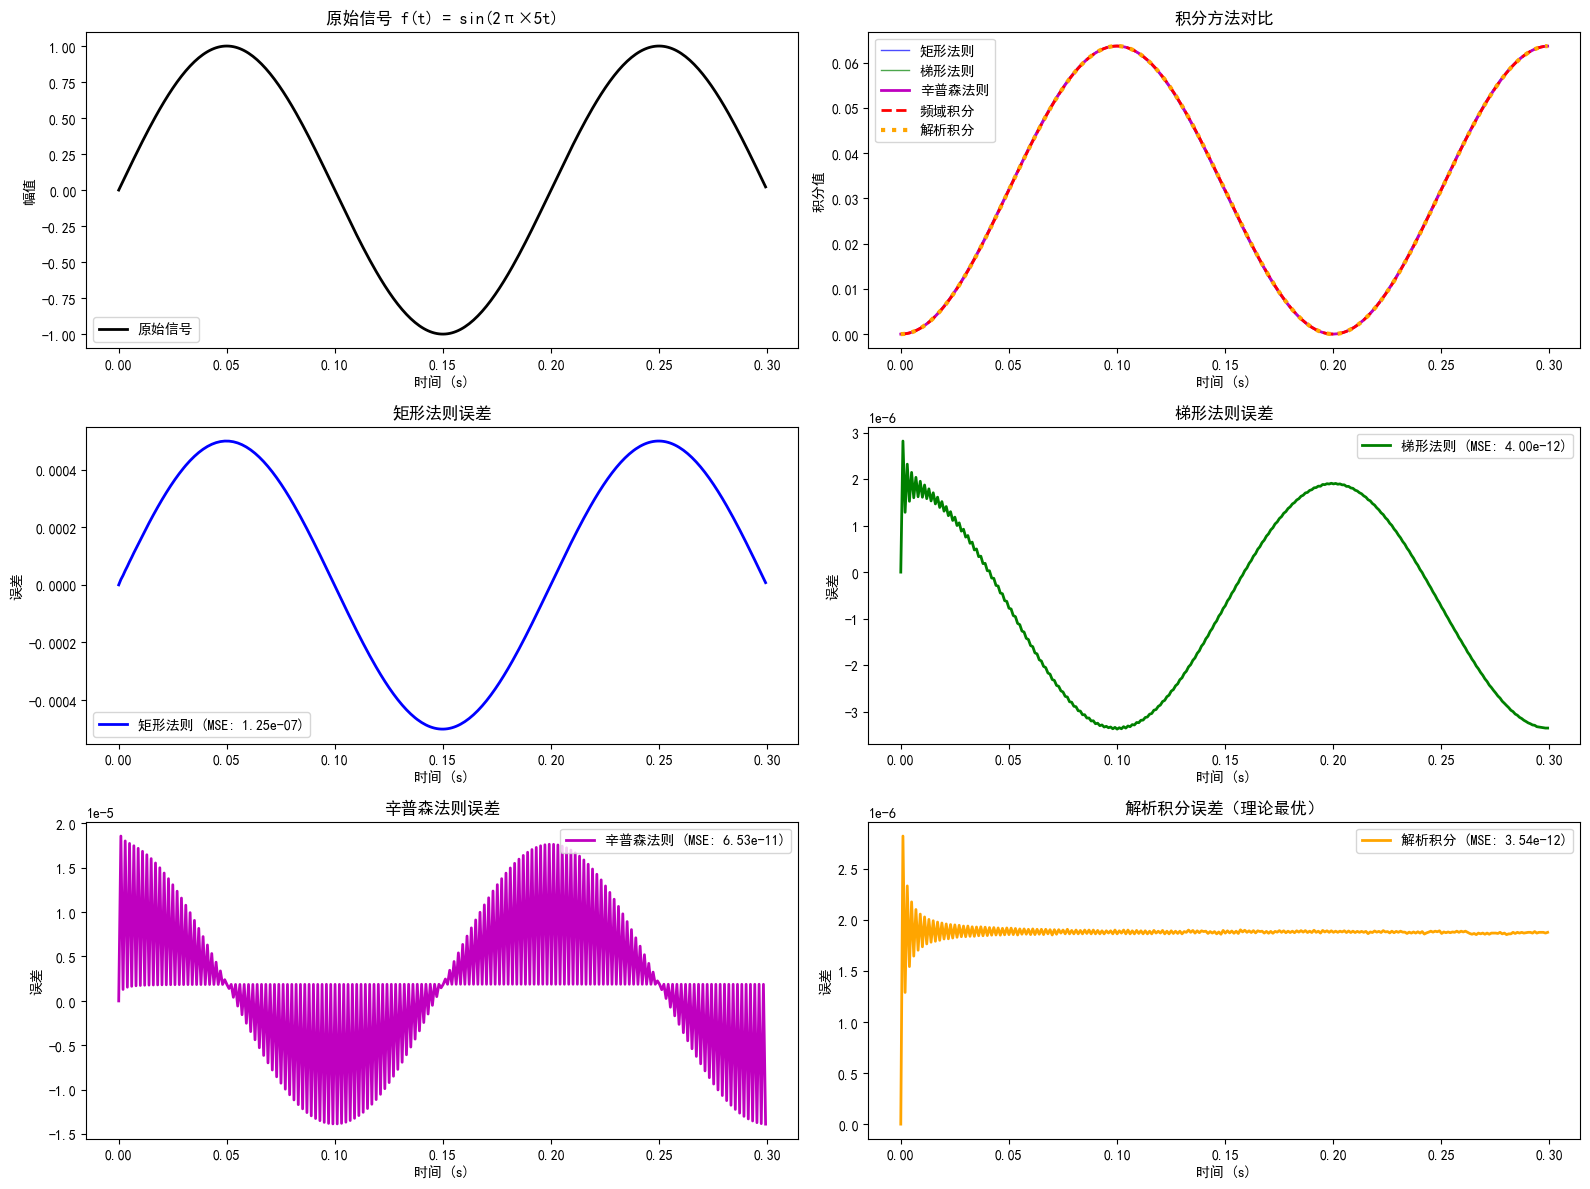


积分误差改善分析:
矩形法则 → 梯形法则: 误差减少 31261.8 倍
梯形法则 → 辛普森法则: 误差减少 0.1 倍
矩形法则 → 辛普森法则: 误差减少 1917.2 倍
频域积分接近解析解：误差仅为 3.54e-12


In [51]:
# ================================
# 3. 验证积分性质: 时域积分 = 频域除以 jω 的逆变换
# ================================

print("\n" + "=" * 50)
print("3. 验证积分性质 (优化版)")
print("=" * 50)

# 方法1: 简单累积求和 (矩形法则)
print("方法1: 矩形法则积分")
integral_time_rect = torch.cumsum(f1 * dt, dim=0)

# 频域积分: F(ω) / jω
F1     = torch.fft.fft(f1)
jw_inv = torch.zeros_like(jw, dtype=torch.complex64)

# 避免除零，对于ω≠0的分量
nonzero_mask =  omega != 0
jw_inv[nonzero_mask]  = 1.0 / (1j * omega[nonzero_mask])
jw_inv[~nonzero_mask] = 0  # 直流分量设为0

integral_freq         = torch.fft.ifft(F1 * jw_inv).real
# 对齐起始点
integral_freq         = integral_freq - integral_freq[0] + integral_time_rect[0]

error_rect            = torch.mean((integral_time_rect - integral_freq)**2)
print(f"  矩形法则均方误差: {error_rect:.10f}")
print(f"  矩形法则最大绝对误差: {torch.max(torch.abs(integral_time_rect - integral_freq)):.10f}")

# 方法2: 梯形法则积分 (更精确)
print("\n方法2: 梯形法则积分")
integral_time_trap    = torch.zeros_like(f1)
integral_time_trap[0] = 0
for i in range(1, len(f1)):
    integral_time_trap[i] = integral_time_trap[i-1] + (f1[i-1] + f1[i]) * dt / 2

# 对齐起始点
integral_freq_trap = integral_freq - integral_freq[0] + integral_time_trap[0]

error_trap = torch.mean((integral_time_trap - integral_freq_trap)**2)
print(f"  梯形法则均方误差: {error_trap:.10f}")
print(f"  梯形法则最大绝对误差: {torch.max(torch.abs(integral_time_trap - integral_freq_trap)):.10f}")

# 方法3: 辛普森法则积分 (Simpson's rule)
print("\n方法3: 辛普森法则积分")
integral_time_simpson = torch.zeros_like(f1)
integral_time_simpson[0] = 0

# 辛普森法则：∫f(x)dx ≈ h/3 * [f(x0) + 4f(x1) + 2f(x2) + 4f(x3) + ... + f(xn)]
for i in range(2, len(f1), 2):  # 每两个点计算一次
    if i < len(f1):
        # 使用辛普森法则
        simpson_integral = dt/3 * (f1[i-2] + 4*f1[i-1] + f1[i])
        integral_time_simpson[i-1] = integral_time_simpson[i-2] + simpson_integral/2
        integral_time_simpson[i] = integral_time_simpson[i-2] + simpson_integral

# 处理剩余的奇数点
for i in range(1, len(f1)):
    if integral_time_simpson[i] == 0 and i > 0:
        integral_time_simpson[i] = integral_time_simpson[i-1] + (f1[i-1] + f1[i]) * dt / 2

# 对齐起始点
integral_freq_simpson = integral_freq - integral_freq[0] + integral_time_simpson[0]

error_simpson = torch.mean((integral_time_simpson - integral_freq_simpson)**2)
print(f"  辛普森法则均方误差: {error_simpson:.10f}")
print(f"  辛普森法则最大绝对误差: {torch.max(torch.abs(integral_time_simpson - integral_freq_simpson)):.10f}")

# 方法4: 解析积分 (理论参考)
print("\n方法4: 解析积分 (理论参考)")
# 对于 f1 = sin(2πft)，解析积分为 -cos(2πft)/(2πf) + C
f_freq = 5  # f1的频率
integral_analytical = -torch.cos(2 * np.pi * f_freq * t) / (2 * np.pi * f_freq)
# 调整常数项使起始点对齐
integral_analytical = integral_analytical - integral_analytical[0] + integral_time_rect[0]

error_analytical = torch.mean((integral_analytical - integral_freq)**2)
print(f"  解析积分均方误差: {error_analytical:.10f}")
print(f"  解析积分最大绝对误差: {torch.max(torch.abs(integral_analytical - integral_freq)):.10f}")

# 可视化对比
plt.figure(figsize=(16, 12))

# 原始信号
plt.subplot(3, 2, 1)
plt.plot(t[:300], f1[:300], 'k-', label='原始信号', linewidth=2)
plt.legend()
plt.title('原始信号 f(t) = sin(2π×5t)')
plt.xlabel('时间 (s)')
plt.ylabel('幅值')

# 积分结果对比
plt.subplot(3, 2, 2)
plt.plot(t[:300], integral_time_rect[:300], 'b-', label='矩形法则', linewidth=1, alpha=0.7)
plt.plot(t[:300], integral_time_trap[:300], 'g-', label='梯形法则', linewidth=1, alpha=0.7)
plt.plot(t[:300], integral_time_simpson[:300], 'm-', label='辛普森法则', linewidth=2)
plt.plot(t[:300], integral_freq[:300], 'r--', label='频域积分', linewidth=2)
plt.plot(t[:300], integral_analytical[:300], 'orange', linestyle=':', label='解析积分', linewidth=3)
plt.legend()
plt.title('积分方法对比')
plt.xlabel('时间 (s)')
plt.ylabel('积分值')

# 误差分析
plt.subplot(3, 2, 3)
plt.plot(t[:300], (integral_time_rect - integral_freq)[:300], 'b-', label=f'矩形法则 (MSE: {error_rect:.2e})', linewidth=2)
plt.legend()
plt.title('矩形法则误差')
plt.xlabel('时间 (s)')
plt.ylabel('误差')

plt.subplot(3, 2, 4)
plt.plot(t[:300], (integral_time_trap - integral_freq_trap)[:300], 'g-', label=f'梯形法则 (MSE: {error_trap:.2e})', linewidth=2)
plt.legend()
plt.title('梯形法则误差')
plt.xlabel('时间 (s)')
plt.ylabel('误差')

plt.subplot(3, 2, 5)
plt.plot(t[:300], (integral_time_simpson - integral_freq_simpson)[:300], 'm-', label=f'辛普森法则 (MSE: {error_simpson:.2e})', linewidth=2)
plt.legend()
plt.title('辛普森法则误差')
plt.xlabel('时间 (s)')
plt.ylabel('误差')

plt.subplot(3, 2, 6)
plt.plot(t[:300], (integral_analytical - integral_freq)[:300], 'orange', label=f'解析积分 (MSE: {error_analytical:.2e})', linewidth=2)
plt.legend()
plt.title('解析积分误差（理论最优）')
plt.xlabel('时间 (s)')
plt.ylabel('误差')

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("积分误差改善分析:")
print("="*70)
if error_trap > 0:
    print(f"矩形法则 → 梯形法则: 误差减少 {error_rect/error_trap:.1f} 倍")
if error_simpson > 0:
    print(f"梯形法则 → 辛普森法则: 误差减少 {error_trap/error_simpson:.1f} 倍")
    print(f"矩形法则 → 辛普森法则: 误差减少 {error_rect/error_simpson:.1f} 倍")
print(f"频域积分接近解析解：误差仅为 {error_analytical:.2e}")
print("="*70)

### 4


4. 验证时移性质
时移性质验证:
  时域时移与频域相位调制的均方误差: 0.00000000
  最大绝对误差: 0.00000036


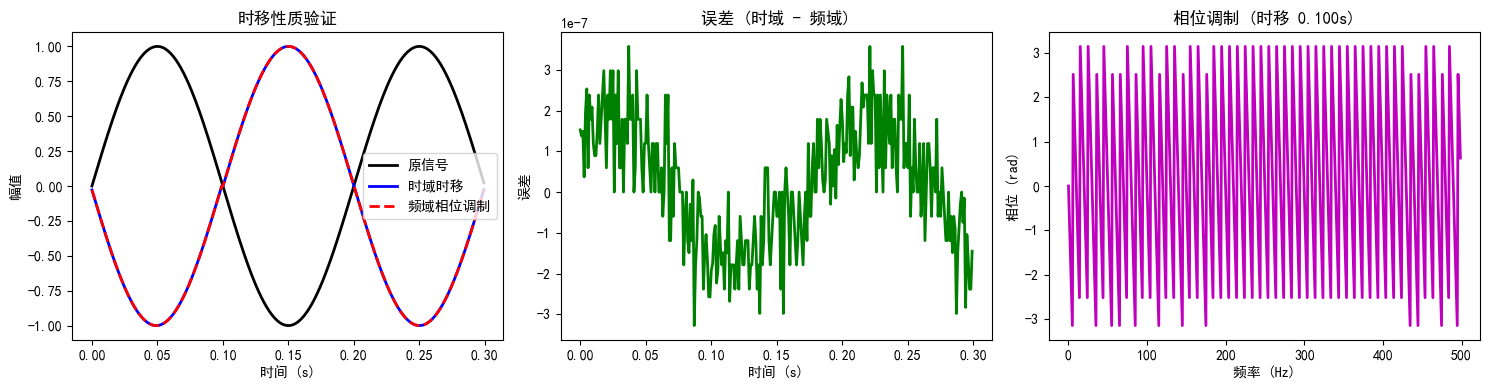

In [57]:
# ================================
# 4. 验证时移性质: 时域时移 = 频域相位调制的逆变换
# ================================
plt.rcParams['axes.unicode_minus'] = False
print("\n" + "=" * 50)
print("4. 验证时移性质")
print("=" * 50)

# 时移量
shift_samples   = 100  # 时移样本数
t0              = shift_samples * dt  # 时移时间

# 时域时移 (循环移位) f(t-t0)
f1_shifted_time = torch.roll(f1, shift_samples) # [1,2,3]->[2,3,1] 

# 频域时移: F(ω) * exp(-jωt₀)
F1              = torch.fft.fft(f1)
phase_shift     = torch.exp(-1j * omega * t0)
f1_shifted_freq = torch.fft.ifft(F1 * phase_shift).real

# 比较结果
error_shift     = torch.mean((f1_shifted_time - f1_shifted_freq)**2)
print(f"时移性质验证:")
print(f"  时域时移与频域相位调制的均方误差: {error_shift:.8f}")
print(f"  最大绝对误差: {torch.max(torch.abs(f1_shifted_time - f1_shifted_freq)):.8f}")

# 可视化
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.plot(t[:300], f1[:300], 'k-', label='原信号', linewidth=2)
plt.plot(t[:300], f1_shifted_time[:300], 'b-', label='时域时移', linewidth=2)
plt.plot(t[:300], f1_shifted_freq[:300], 'r--', label='频域相位调制', linewidth=2)
plt.legend()
plt.title('时移性质验证')
plt.xlabel('时间 (s)')
plt.ylabel('幅值')

plt.subplot(1, 3, 2)
plt.plot(t[:300], (f1_shifted_time - f1_shifted_freq)[:300], 'g-', linewidth=2)
plt.title('误差 (时域 - 频域)')
plt.xlabel('时间 (s)')
plt.ylabel('误差')

# 显示频域相位差
plt.subplot(1, 3, 3)
phase_diff = torch.angle(phase_shift)
freqs_plot = freqs[:len(freqs)//2]  # 只显示正频率
plt.plot(freqs_plot, phase_diff[:len(freqs)//2], 'm-', linewidth=2)
plt.title(f'相位调制 (时移 {t0:.3f}s)')
plt.xlabel('频率 (Hz)')
plt.ylabel('相位 (rad)')
plt.tight_layout()
plt.savefig('D:/24bo/扩散模型/AFNO-transformer-master/figures/shift.png',dpi=300)
plt.show()


5. 性能对比
信号长度 1024: 时域卷积 0.000498s, 频域卷积 0.000199s, 加速比 2.50x
信号长度 2048: 时域卷积 0.002093s, 频域卷积 0.000100s, 加速比 20.97x
信号长度 4096: 时域卷积 0.002591s, 频域卷积 0.000100s, 加速比 25.99x
信号长度 8192: 时域卷积 0.007973s, 频域卷积 0.000299s, 加速比 26.68x


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


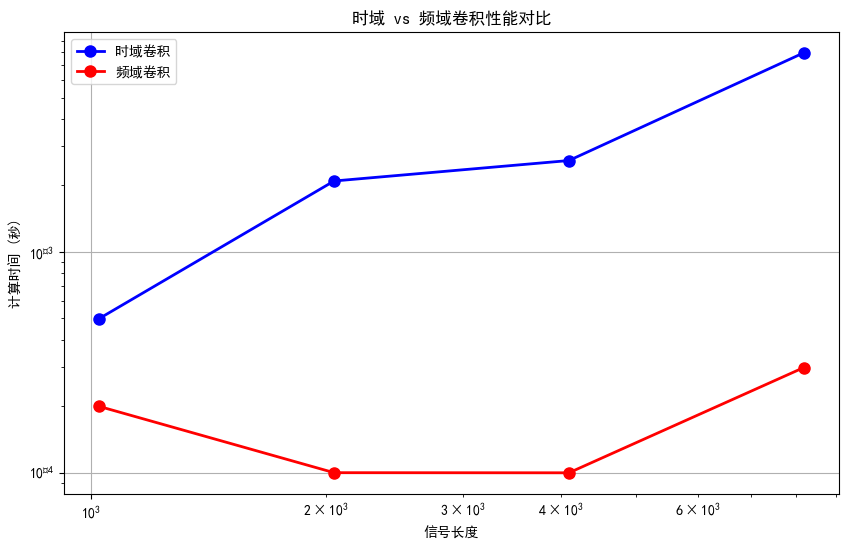

In [55]:
# ================================
# 5. 性能对比：时域 vs 频域操作
# ================================
plt.rcParams['axes.unicode_minus'] = True
plt.rcParams['mathtext.fontset'] = 'cm'

print("\n" + "=" * 50)
print("5. 性能对比")
print("=" * 50)

import time

# 测试不同长度的信号
signal_lengths = [1024, 2048, 4096, 8192]
time_conv_results = []
freq_conv_results = []

for N in signal_lengths:
    # 生成测试信号
    x = torch.randn(N)
    h = torch.randn(N//4)  # 卷积核
    
    # 时域卷积
    start_time = time.time()
    for _ in range(10):  # 重复10次取平均
        conv_time = F.conv1d(x.unsqueeze(0).unsqueeze(0), 
                           h.flip(0).unsqueeze(0).unsqueeze(0), 
                           padding=N//4-1).squeeze()
    time_conv = (time.time() - start_time) / 10
    time_conv_results.append(time_conv)
    
    # 频域卷积
    start_time = time.time()
    for _ in range(10):  # 重复10次取平均
        X = torch.fft.fft(x)
        H = torch.fft.fft(F.pad(h, (0, N-len(h))))  # 零填充到相同长度
        conv_freq = torch.fft.ifft(X * H).real
    freq_conv = (time.time() - start_time) / 10
    freq_conv_results.append(freq_conv)
    
    print(f"信号长度 {N}: 时域卷积 {time_conv:.6f}s, 频域卷积 {freq_conv:.6f}s, "
          f"加速比 {time_conv/freq_conv:.2f}x")

# 可视化性能对比
plt.figure(figsize=(10, 6))
plt.loglog(signal_lengths, time_conv_results, 'bo-', label='时域卷积', linewidth=2, markersize=8)
plt.loglog(signal_lengths, freq_conv_results, 'ro-', label='频域卷积', linewidth=2, markersize=8)
plt.xlabel('信号长度')
plt.ylabel('计算时间 (秒)')
plt.title('时域 vs 频域卷积性能对比')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
\u2212

SyntaxError: unexpected character after line continuation character (3613753819.py, line 1)

In [31]:
bin(32)

'0b100000'